<a href="https://colab.research.google.com/github/leonormira/CIFO-Project/blob/main/Santiago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('..')

In [2]:
import random
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from typing import Callable
from copy import deepcopy
import itertools
from tqdm import tqdm

In [3]:
SEED = 26
random.seed(SEED)
np.random.seed(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path_file = '/content/drive/MyDrive/CIFO_Project/players(in).csv'

In [6]:
players_df = pd.read_csv(path_file, index_col=0)

In [7]:
class Player():

    def __init__(self, player):
        self.name = player["Name"]
        self.position = player["Position"]
        self.skill = player["Skill"]
        self.salary = player["Salary (€M)"]

    def __repr__(self):
        return f"{self.name} - {self.position}"

    # para comparar jogadores com os mesmos dados
    def __eq__(self, other):
        if not isinstance(other, Player):
            return False
        return self.name == other.name and self.position == other.position

    def __hash__(self):  # NAO FACO A MINIMA
        return hash((self.name, self.position))

In [8]:
class Team():

    def __init__(self, name, budget):

        self.budget = budget
        self.name = name
        self.goalkeepers = []
        self.defenders = []
        self.midfielders = []
        self.forwards = []

    def add_player(self, player):
        if player.position == "GK":
            self.goalkeepers.append(player)
        if player.position == "DEF":
            self.defenders.append(player)
        if player.position == "MID":
            self.midfielders.append(player)
        if player.position == "FWD":
            self.forwards.append(player)

    def total_salary(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def average_skill(self):
        return statistics.mean([p.skill for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def over_budget(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards]) > self.budget

In [9]:
class League():

    def __init__(self, crossover_function, mutation_function): # deviamos meter aqui o budget
        self.crossover_function = crossover_function
        self.mutation_function = mutation_function
        self.teams = [
            Team("Team 1", 750),
            Team("Team 2", 750),
            Team("Team 3", 750),
            Team("Team 4", 750),
            Team("Team 5", 750)
        ]

    def valid_league(self):
        players = [p for t in self.teams for p in t.goalkeepers + t.defenders + t.midfielders + t.forwards]
        return len(set(players)) == len(players)


    def allocate_players_from_lists(self, goalkeepers, defenders, midfielders, forwards):
        # Clear teams
        for team in self.teams:
            team.goalkeepers = []
            team.defenders = []
            team.midfielders = []
            team.forwards = []

        for i, team in enumerate(self.teams):
            team.add_player(goalkeepers[i])
            team.add_player(defenders[i * 2])
            team.add_player(defenders[i * 2 + 1])
            team.add_player(midfielders[i * 2])
            team.add_player(midfielders[i * 2 + 1])
            team.add_player(forwards[i * 2])
            team.add_player(forwards[i * 2 + 1])


    def draft_players(self, players):

        # Separate players by position
        goalkeepers = [p for p in players if p.position == "GK"]
        defenders = [p for p in players if p.position == "DEF"]
        midfielders = [p for p in players if p.position == "MID"]
        forwards = [p for p in players if p.position == "FWD"]

        random.shuffle(goalkeepers)
        random.shuffle(defenders)
        random.shuffle(midfielders)
        random.shuffle(forwards)

        self.allocate_players_from_lists(goalkeepers, defenders, midfielders, forwards)


    def show_teams(self):
        for team in self.teams:
            print(f"\n{team.name}")
            for player in team.goalkeepers + team.defenders + team.midfielders + team.forwards:
                print(f"{player.name} - {player.position}")

    def fitness(self):
        std = statistics.stdev([team.average_skill() for team in self.teams])
        over_budget_count = sum(team.over_budget() for team in self.teams)
        return std + over_budget_count


    def player_positions(self):
        player_positions = {
            "GK": [p for t in self.teams for p in t.goalkeepers],
            "DEF": [p for t in self.teams for p in t.defenders],
            "MID": [p for t in self.teams for p in t.midfielders],
            "FWD": [p for t in self.teams for p in t.forwards]
        }
        return player_positions

    #def mutation(self, mut_prob):
        #return self

    def mutation(self, mut_prob):
        player_positions = self.player_positions()

        self.mutation_function(player_positions["GK"], mut_prob)
        self.mutation_function(player_positions["DEF"], mut_prob)
        self.mutation_function(player_positions["MID"], mut_prob)
        self.mutation_function(player_positions["FWD"], mut_prob)

        mutated_team = League(self.crossover_function, self.mutation_function)
        mutated_team.allocate_players_from_lists(player_positions["GK"], player_positions["DEF"], player_positions["MID"], player_positions["FWD"])

        return mutated_team


    def crossover(self, other_solution):
        parent1_positions = self.player_positions()
        parent2_positions = other_solution.player_positions()

        offspring1_goalkeepers, offspring2_goalkeepers = self.crossover_function(parent1_positions["GK"], parent2_positions["GK"])
        offspring1_defenders, offspring2_defenders = self.crossover_function(parent1_positions["DEF"], parent2_positions["DEF"])
        offspring1_midfielders, offspring2_midfielders = self.crossover_function(parent1_positions["MID"], parent2_positions["MID"])
        offspring1_forwards, offspring2_forwards = self.crossover_function(parent1_positions["FWD"], parent2_positions["FWD"])

        # Create new leagues and allocate players
        offspring1 = League(self.crossover_function, self.mutation_function)
        offspring1.allocate_players_from_lists(offspring1_goalkeepers, offspring1_defenders, offspring1_midfielders, offspring1_forwards)

        offspring2 = League(self.crossover_function, self.mutation_function)
        offspring2.allocate_players_from_lists(offspring2_goalkeepers, offspring2_defenders, offspring2_midfielders, offspring2_forwards)

        return offspring1, offspring2


In [10]:
def shift_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        sub = new_representation[first_idx:second_idx + 1]
        sub = [sub[-1]] + sub[:-1]
        new_representation[first_idx:second_idx + 1] = sub

    return new_representation

In [11]:
def invertion_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)
    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        new_representation[first_idx:second_idx + 1] = reversed(new_representation[first_idx:second_idx + 1])

    return new_representation


In [12]:
def swap_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx
        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        new_representation[first_idx] = repr[second_idx]
        new_representation[second_idx] = repr[first_idx]

        return new_representation

In [13]:
def swap_crossover(parent1_repr: str | list, parent2_repr: str | list):

    size = len(parent1_repr)
    offspring1_repr = parent1_repr.copy()
    offspring2_repr = parent1_repr.copy()

    def swap(parent1_repr, parent2_repr):
        offspring_repr = parent1_repr.copy()
        # Randomly choose 1 position to perform a swap
        swap_positions = random.sample(range(size), 1)

        for pos in swap_positions:
            val_from_p2 = parent2_repr[pos]
            index_in_child = offspring_repr.index(val_from_p2)

            offspring_repr[pos], offspring_repr[index_in_child] = offspring_repr[index_in_child], offspring_repr[pos]

        return offspring_repr

    offspring1_repr = swap(parent1_repr=parent1_repr, parent2_repr=parent2_repr)
    offspring2_repr = swap(parent1_repr=parent2_repr, parent2_repr=parent1_repr)

    return offspring1_repr, offspring2_repr

In [14]:
def cycle_crossover(parent1_repr, parent2_repr):
    initial_random_idx = random.randint(0, len(parent1_repr) -1)

    cycle_idxs = [initial_random_idx]
    current_cycle_idx = initial_random_idx

    while True:
        value_parent2 = parent2_repr[current_cycle_idx]

        next_cycle_idx = parent1_repr.index(value_parent2)

        if next_cycle_idx in cycle_idxs:
            break

        cycle_idxs.append(next_cycle_idx)
        current_cycle_idx = next_cycle_idx

    offspring1_repr = []
    offspring2_repr = []

    for idx in range(len(parent1_repr)):
        if idx in cycle_idxs:
            offspring1_repr.append(parent2_repr[idx])
            offspring2_repr.append(parent1_repr[idx])

        else:
            offspring1_repr.append(parent1_repr[idx])
            offspring2_repr.append(parent2_repr[idx])

    if isinstance(parent1_repr, str) and isinstance(parent2_repr, str):
        offspring1_repr = "". join(offspring1_repr)
        offspring2_repr = "". join(offspring2_repr)

    return offspring1_repr, offspring2_repr

In [15]:
def tournament_selection(population: list[League], maximization: bool, tournament_size: int = 4):

    tournament = random.sample(population, tournament_size)
    return deepcopy(get_best_ind(tournament, maximization))

In [16]:
def fitness_proportionate_selection(population: list[League], maximization: bool):
    # total_fitness = sum([ind.fitness() for ind in population])

    if maximization:
        fitness_values = [ind.fitness() for ind in population]
    else:
        # Minimization: Use the inverse of the fitness value
        # Lower fitness should have higher probability of being selected
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    # Generate random number between 0 and total
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0
    # For each individual, check if random number is inside the individual's "box"
    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

In [17]:
def get_best_ind(population: list[League], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

In [18]:
def genetic_algorithm(
    initial_population: list[League],   # MUDAR ISTO PARA LISTA DE SOLUTION
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    ):

    population = initial_population
    fitness_list = []

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f"------------ Generation {gen} ------------")

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first_ind = selection_algorithm(population=population, maximization=maximization)

            second_ind = selection_algorithm(population=population, maximization=maximization)

            if verbose:
                print(f"Selected Individuals: \n{first_ind}\n{second_ind}")

            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print("Applied Crossover")
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print("Not Applied Replication")

            if verbose:
                print(f"Offspring 1: {offspring1}\n{offspring2}")

            first_new_ind = offspring1.mutation(mut_prob)
            new_population.append(first_new_ind)

            if verbose:
                print(f"First mutated individual: {first_new_ind}")

            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f"Second mutated individual: {second_new_ind}")

        population = new_population
        fitness_list.append(get_best_ind(population, maximization).fitness())

        if verbose:
            print(f"Final Best Individual in Generation: {get_best_ind(population, maximization)}")

    return get_best_ind(population, maximization), fitness_list


Best solution: (<__main__.League object at 0x7a2ba39b8710>, [0.35571141708538767, 0.35571141708538767, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.1195228609334

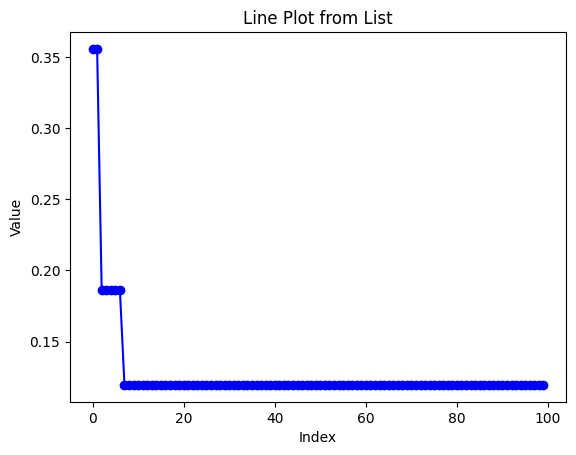

In [26]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(cycle_crossover, swap_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.1,
    verbose=False
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot from List')

# Show the plot
plt.show()

In [ ]:
best_solution[0].show_teams()


Team 1
Chris Thompson - GK
Owen Parker - DEF
Mason Reed - DEF
Spencer Ward - MID
Dylan Morgan - MID
Adrian Collins - FWD
Sebastian Perry - FWD

Team 2
Alex Carter - GK
Caleb Fisher - DEF
Maxwell Flores - DEF
Gavin Richardson - MID
Ashton Phillips - MID
Chase Murphy - FWD
Julian Scott - FWD

Team 3
Ryan Mitchell - GK
Logan Brooks - DEF
Jaxon Griffin - DEF
Connor Hayes - MID
Hunter Cooper - MID
Colton Gray - FWD
Elijah Sanders - FWD

Team 4
Blake Henderson - GK
Daniel Foster - DEF
Lucas Bennett - DEF
Nathan Wright - MID
Dominic Bell - MID
Zachary Nelson - FWD
Tyler Jenkins - FWD

Team 5
Jordan Smith - GK
Ethan Howard - DEF
Brayden Hughes - DEF
Austin Torres - MID
Bentley Rivera - MID
Xavier Bryant - FWD
Landon Powell - FWD


In [ ]:
for team in best_solution[0].teams:
    print(team.average_skill() )
    print(team.total_salary())

86.42857142857143
695
86.42857142857143
677
86.28571428571429
700
86.57142857142857
672
86.28571428571429
680


In [34]:
def select_team_variants(df: pd.DataFrame):
    positions = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2}
    variants = {}

    for criterion, sort_order in [("highest_skill", False), ("lowest_skill", True), ("highest_salary", False)]:
        selected_players = []

        for pos, count in positions.items():
            # Filter by position
            df_pos = df[df["Position"] == pos]

            if criterion == "highest_salary":
                df_sorted = df_pos.sort_values(by="Salary (€M)", ascending=sort_order)
            else:  # skill-based
                df_sorted = df_pos.sort_values(by="Skill", ascending=sort_order)

            # Select top N players
            selected = df_sorted.head(count)
            selected_players.extend(selected.to_dict(orient="records"))

        variants[criterion] = selected_players

    return variants

In [36]:
team_variants = select_team_variants(players_df)

highest_skill_team = team_variants["highest_skill"]
lowest_skill_team = team_variants["lowest_skill"]
highest_salary_team = team_variants["highest_salary"]

# Example: print names or info
for player in highest_skill_team:
    print(player) #637

for player in lowest_skill_team:
    print(player) # 569

for player in highest_salary_team:
    print(player)   # 835

{'Name': 'Jordan Smith', 'Position': 'GK', 'Skill': 88, 'Salary (€M)': 100}
{'Name': 'Daniel Foster', 'Position': 'DEF', 'Skill': 90, 'Salary (€M)': 110}
{'Name': 'Owen Parker', 'Position': 'DEF', 'Skill': 88, 'Salary (€M)': 100}
{'Name': 'Nathan Wright', 'Position': 'MID', 'Skill': 92, 'Salary (€M)': 120}
{'Name': 'Dylan Morgan', 'Position': 'MID', 'Skill': 91, 'Salary (€M)': 115}
{'Name': 'Sebastian Perry', 'Position': 'FWD', 'Skill': 95, 'Salary (€M)': 150}
{'Name': 'Elijah Sanders', 'Position': 'FWD', 'Skill': 93, 'Salary (€M)': 140}
{'Name': 'Chris Thompson', 'Position': 'GK', 'Skill': 80, 'Salary (€M)': 80}
{'Name': 'Jaxon Griffin', 'Position': 'DEF', 'Skill': 79, 'Salary (€M)': 65}
{'Name': 'Ethan Howard', 'Position': 'DEF', 'Skill': 80, 'Salary (€M)': 70}
{'Name': 'Austin Torres', 'Position': 'MID', 'Skill': 82, 'Salary (€M)': 80}
{'Name': 'Hunter Cooper', 'Position': 'MID', 'Skill': 83, 'Salary (€M)': 85}
{'Name': 'Tyler Jenkins', 'Position': 'FWD', 'Skill': 80, 'Salary (€M)':

In [27]:
players_df

,Name,Position,Skill,Salary (€M)
0,Alex Carter,GK,85,90
1,Jordan Smith,GK,88,100
2,Ryan Mitchell,GK,83,85
3,Chris Thompson,GK,80,80
4,Blake Henderson,GK,87,95
5,Daniel Foster,DEF,90,110
6,Lucas Bennett,DEF,85,90
7,Owen Parker,DEF,88,100
8,Ethan Howard,DEF,80,70
9,Mason Reed,DEF,82,75


Team 1
Jordan Smith - GK
Caleb Fisher - DEF
Maxwell Flores - DEF
Connor Hayes - MID
Spencer Ward - MID
Elijah Sanders - FWD
Chase Murphy - FWD

Team 2
Blake Henderson - GK
Owen Parker - DEF
Jaxon Griffin - DEF
Hunter Cooper - MID
Nathan Wright - MID
Adrian Collins - FWD
Colton Gray - FWD

Team 3
Chris Thompson - GK
Brayden Hughes - DEF
Mason Reed - DEF
Bentley Rivera - MID
Gavin Richardson - MID
Zachary Nelson - FWD
Sebastian Perry - FWD

Team 4
Alex Carter - GK
Ethan Howard - DEF
Lucas Bennett - DEF
Austin Torres - MID
Dylan Morgan - MID
Julian Scott - FWD
Xavier Bryant - FWD

Team 5
Ryan Mitchell - GK
Daniel Foster - DEF
Logan Brooks - DEF
Dominic Bell - MID
Ashton Phillips - MID
Landon Powell - FWD
Tyler Jenkins - FWD

# RUNNING LOTS OF TIMES

In [37]:
POP_SIZE = 10
GENERATIONS = 20

grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.9
        },
        {
            "function": swap_crossover,
            "xo_prob": 0.9
        }
    ],
    "mutation": [
        {
            "function": shift_mutation,
            "mut_prob": 0.1
        },
        {
            "function": invertion_mutation,
            "mut_prob": 0.1
        },
        {
            "function": swap_mutation,
            "mut_prob": 0.1
        }
    ],
    "selection": [
        {
            "function": fitness_proportionate_selection,
            "maximization": False
        },
        {
            "function": tournament_selection,
            "tournament_size": 4,
            "maximization": False
        }
    ]
    #"elitism": [True, False]                       # ELETISM CONFIGS
}

fitness_dfs = {}

#grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"], grid_params["elitism"]))
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))                     # ELETISM CONFIGS

print(f"Number of configs: {len(grid)}")


#for crossover_cfg, mutation_cfg, selection_cfg, elitism in tqdm(grid):
for crossover_cfg, mutation_cfg, selection_cfg in grid:             # UNCOMMENT FOR ELETISM CONFIGS

    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    selection_function = selection_cfg["function"]
    if selection_function == tournament_selection:
        tournament_size = selection_cfg["tournament_size"]
    maximization = selection_cfg["maximization"]

    config_results = []

    for run_nr in tqdm(range(30)):



        initial_population = []

        for _ in range(POP_SIZE):
            players = [Player(row) for _, row in players_df.iterrows()]
            league = League(swap_crossover, swap_mutation)
            league.draft_players(players)
            initial_population.append(league)

        _, fitness_over_gens = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=fitness_proportionate_selection,
            maximization=False,
            mut_prob=0.1,
            verbose=False
        )
        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

        selection_name = selection_function.__name__
        if selection_function == tournament_selection:
            selection_name += f"(k={selection_cfg['tournament_size']})"

        config_label = (
          f"{crossover_function.__name__}{xo_prob}_"
          f"{mutation_function.__name__}{mut_prob}_"
          f"{selection_name}"
          #f"_elitism={elitism}"      # UNCOMMENT FOR ELETISM CONFIGS
        )

    df.to_csv(f"results/fitness_{config_label}.csv", index=False)

    fitness_dfs[config_label] = df


Number of configs: 12


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


OSError: Cannot save file into a non-existent directory: 'results'

In [ ]:
print(fitness_dfs.keys())

dict_keys(['cycle_crossover0.9_shift_mutation0.1_fitness_proportionate_selection', 'cycle_crossover0.9_shift_mutation0.1_tournament_selection(k=4)', 'cycle_crossover0.9_invertion_mutation0.1_fitness_proportionate_selection', 'cycle_crossover0.9_invertion_mutation0.1_tournament_selection(k=4)', 'cycle_crossover0.9_swap_mutation0.1_fitness_proportionate_selection', 'cycle_crossover0.9_swap_mutation0.1_tournament_selection(k=4)', 'swap_crossover0.9_shift_mutation0.1_fitness_proportionate_selection', 'swap_crossover0.9_shift_mutation0.1_tournament_selection(k=4)', 'swap_crossover0.9_invertion_mutation0.1_fitness_proportionate_selection', 'swap_crossover0.9_invertion_mutation0.1_tournament_selection(k=4)', 'swap_crossover0.9_swap_mutation0.1_fitness_proportionate_selection', 'swap_crossover0.9_swap_mutation0.1_tournament_selection(k=4)'])


In [ ]:
fitness_dfs["cycle_crossover0.9_shift_mutation0.1_fitness_proportionate_selection"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.583795,0.583795,0.519026,0.519026,0.467298,0.467298,0.467298,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307
1,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067,0.341067
2,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926,0.444926
3,0.583795,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368,0.421368
4,0.778539,0.695466,0.657764,0.657764,0.657764,0.519026,0.519026,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298,0.467298
5,0.758624,0.758624,0.758624,0.758624,0.609449,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979,0.498979
6,0.528764,0.444926,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307,0.433307
7,0.528764,0.528764,0.528764,0.292770,0.292770,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551,0.255551
8,0.771957,0.751868,0.592470,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764
9,0.665475,0.665475,0.509101,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764,0.325764


In [ ]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """

    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        std_fitness = df.std(axis=0)
        median_fitness = df.median(axis=0)

        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[0].fill_between(
            mean_fitness.index,
            mean_fitness.values - std_fitness.values,
            mean_fitness.values + std_fitness.values,
            alpha=0.2)


        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

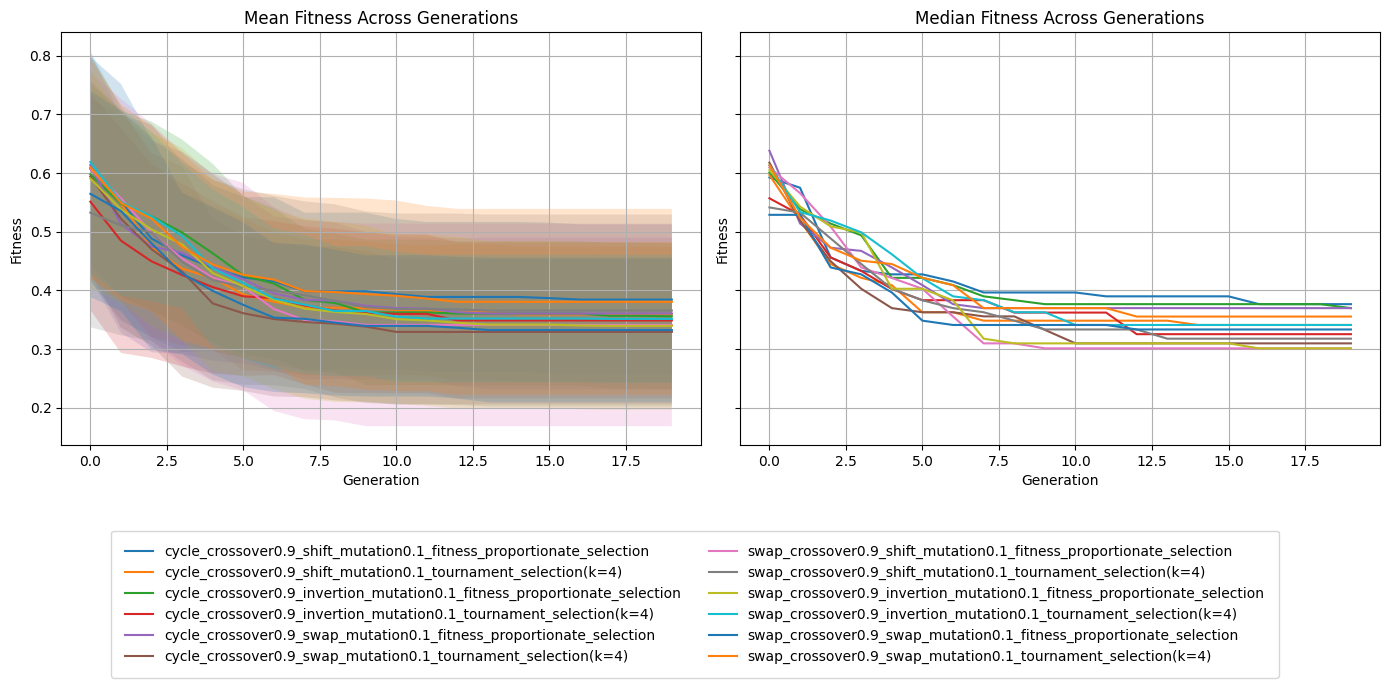

In [ ]:
plot_fitness_over_gen(fitness_dfs)

In [ ]:
from itertools import combinations
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

In [ ]:
last_gen_fitness = {
    label: df.iloc[:, -1].values  # assumes last column is final gen
    for label, df in fitness_dfs.items()
}

results = []
labels = list(last_gen_fitness.keys())

for a, b in combinations(labels, 2):
    stat, p = wilcoxon(last_gen_fitness[a], last_gen_fitness[b])
    results.append((a, b, stat, p))

# Convert to DataFrame
wilcoxon_df = pd.DataFrame(results, columns=["Config A", "Config B", "Statistic", "P-Value"])

# Apply Bonferroni or Benjamini-Hochberg correction
wilcoxon_df["p_adj"] = multipletests(wilcoxon_df["P-Value"], method="bonferroni")[1]  # or method="fdr_bh"

# Optional: flag significant comparisons
wilcoxon_df["Significant"] = wilcoxon_df["p_adj"] < 0.05

In [ ]:
wilcoxon_df[wilcoxon_df["Significant"] == True]

,Config A,Config B,Statistic,P-Value,p_adj,Significant
